# Simulation Study

In [1]:
%run -i ./preamble.py
%config InlineBackend.figure_format = 'retina'
%load_ext nb_black

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
# dill.load_session("Sim_Poisson_Depexp.pkl")

In [3]:
import sys

print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("PyMC3 version:", pm.__version__)
print("Arviz version:", arviz.__version__)

tic()

Python version: 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 15:45:16) 
[GCC 9.3.0]
Numpy version: 1.20.2
PyMC3 version: 3.11.2
Arviz version: 0.11.2


In [4]:
FAST = False

# Processor information and SMC calibration parameters
if not FAST:
    numIters = 7
    numItersData = 10
    popSize = 1000
    epsMin = 0
    timeout = 1000
else:
    numIters = 5
    numItersData = 10
    popSize = 500
    epsMin = 1
    timeout = 30

smcArgs = {"timeout": timeout, "verbose": True}
smcArgs["numProcs"] = 64

## Inference of a Poison- Frequency Dependent Exponential model

In this notebook we are are conducting a simulation experiment where the claim frequency are Negative Binomial distributed 

$$
n_s\underset{\textbf{i.i.d.}}{\sim}\text{Pois}(\lambda = 5),\text{ }s = 1,\ldots, 30
$$ 

and the individual claim sizes are freqency dependent exponential which means that 

$$
u_1,\ldots, u_{n_s}|n_s\underset{\textbf{i.i.d.}}{\sim}\text{Exp}(\beta\times e^{\delta n_s}),\text{ }s = 1,\ldots 30,
$$ 
where we set $\beta = 2$ and $\delta = 0.2$.

The available data is the total claim sizes, we have 

$$
x_s = \sum_{k = 1}^{n_s}u_k,\text{ }s = 1,\ldots, t.
$$

Our aim is to see if ABC is able to fit this model featuring dependency between claim counts and claim frequency. 

In [5]:
rg = default_rng(123)

sample_sizes = [50, 250]
T = sample_sizes[-1]
t = np.arange(1, T + 1, 1)

# Frequency-Loss Model
λ, β, δ = 4, 2, 0.2
θ_True = λ, β, δ
θ_sev = β, δ
θ_freq = λ
sev = "frequency dependent exponential"
freq = "poisson"

# Aggregation process
psi = abcre.Psi("sum")

freqs, sevs = abcre.simulate_claim_data(rg, T, freq, sev, θ_True)
df_full = pd.DataFrame(
    {
        "time_period": np.concatenate([np.repeat(s, freqs[s - 1]) for s in t]),
        "claim_size": sevs,
        "N": np.concatenate([np.repeat(freqs[s - 1], freqs[s - 1]) for s in t]),
    }
)

xData = abcre.compute_psi(freqs, sevs, psi)

df_agg = pd.DataFrame({"time_period": t, "N": freqs, "X": xData})

In [6]:
[np.sum(xData[:ss] > 0) for ss in sample_sizes]

[47, 245]

## True posterior samples

We run a Bayesian analysis on the individual claim data and frequency data so as to infer the parameters of the Poisson and dependent exponential distribution. The prior distribution on the parameters are taken as independent uniform distribution (as in the ABC approach). 

### Fitting a dependent exponential model to the individual loss data

In [7]:
dfsev = pd.DataFrame({"ss": [], "β": [], "δ": []})

for ss in sample_sizes:

    fullData = df_full[df_full.time_period <= ss]
    print("The number of individual claim sizes is ", len(fullData))
    with pm.Model() as model:

        # Weakly informative priors,
        β = pm.Uniform("β", lower=0, upper=10)
        δ = pm.Uniform("δ", lower=-1, upper=1)

        # Poisson likelihood
        u = pm.Exponential(
            "u",
            lam=np.exp(-δ * fullData["N"].values) / β,
            observed=fullData["claim_size"].values,
        )
        %time trace = pm.sample_smc(popSize, random_seed=134, chains = 1)
        res = pd.DataFrame(
            {"ss": np.repeat(ss, popSize), "β": trace["β"], "δ": trace["δ"],}
        )

    dfsev = pd.concat([dfsev, res])

The number of individual claim sizes is  178


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.020
Stage:   2 Beta: 0.072
Stage:   3 Beta: 0.208
Stage:   4 Beta: 0.675
Stage:   5 Beta: 1.000


CPU times: user 1.94 s, sys: 64.3 ms, total: 2 s
Wall time: 3.07 s
The number of individual claim sizes is  1017


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.003
Stage:   2 Beta: 0.013
Stage:   3 Beta: 0.039
Stage:   4 Beta: 0.125
Stage:   5 Beta: 0.399
Stage:   6 Beta: 1.000


CPU times: user 2.41 s, sys: 95 µs, total: 2.41 s
Wall time: 2.41 s


### Fitting a Poisson model to the claim frequency data

Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.037
Stage:   1 Beta: 0.271
Stage:   2 Beta: 1.000


CPU times: user 783 ms, sys: 7.95 ms, total: 791 ms
Wall time: 794 ms


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.008
Stage:   1 Beta: 0.062
Stage:   2 Beta: 0.474
Stage:   3 Beta: 1.000


CPU times: user 831 ms, sys: 0 ns, total: 831 ms
Wall time: 830 ms


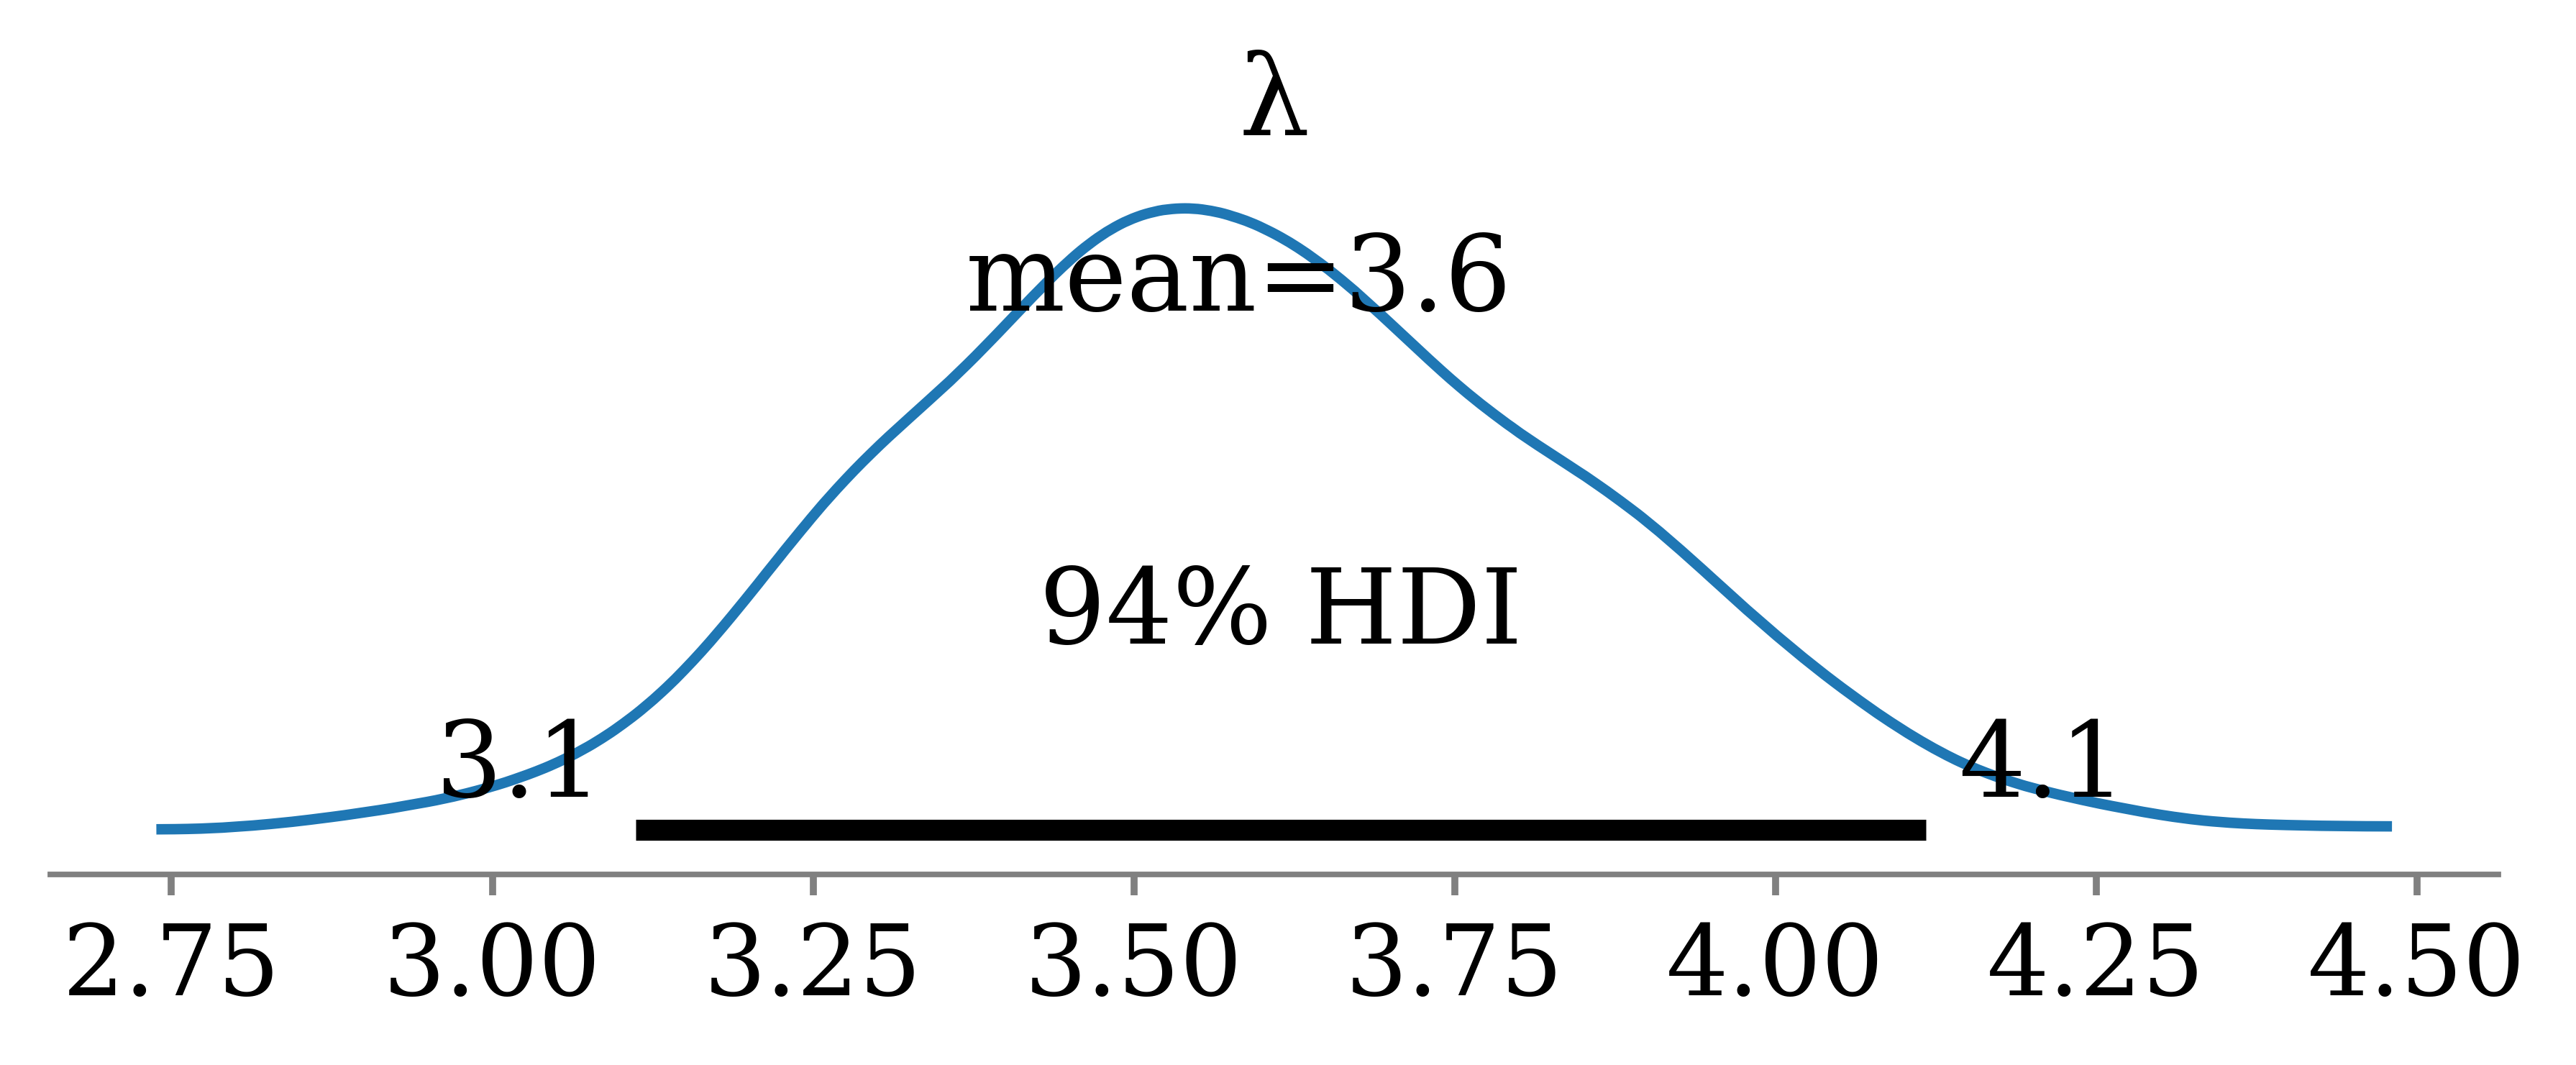

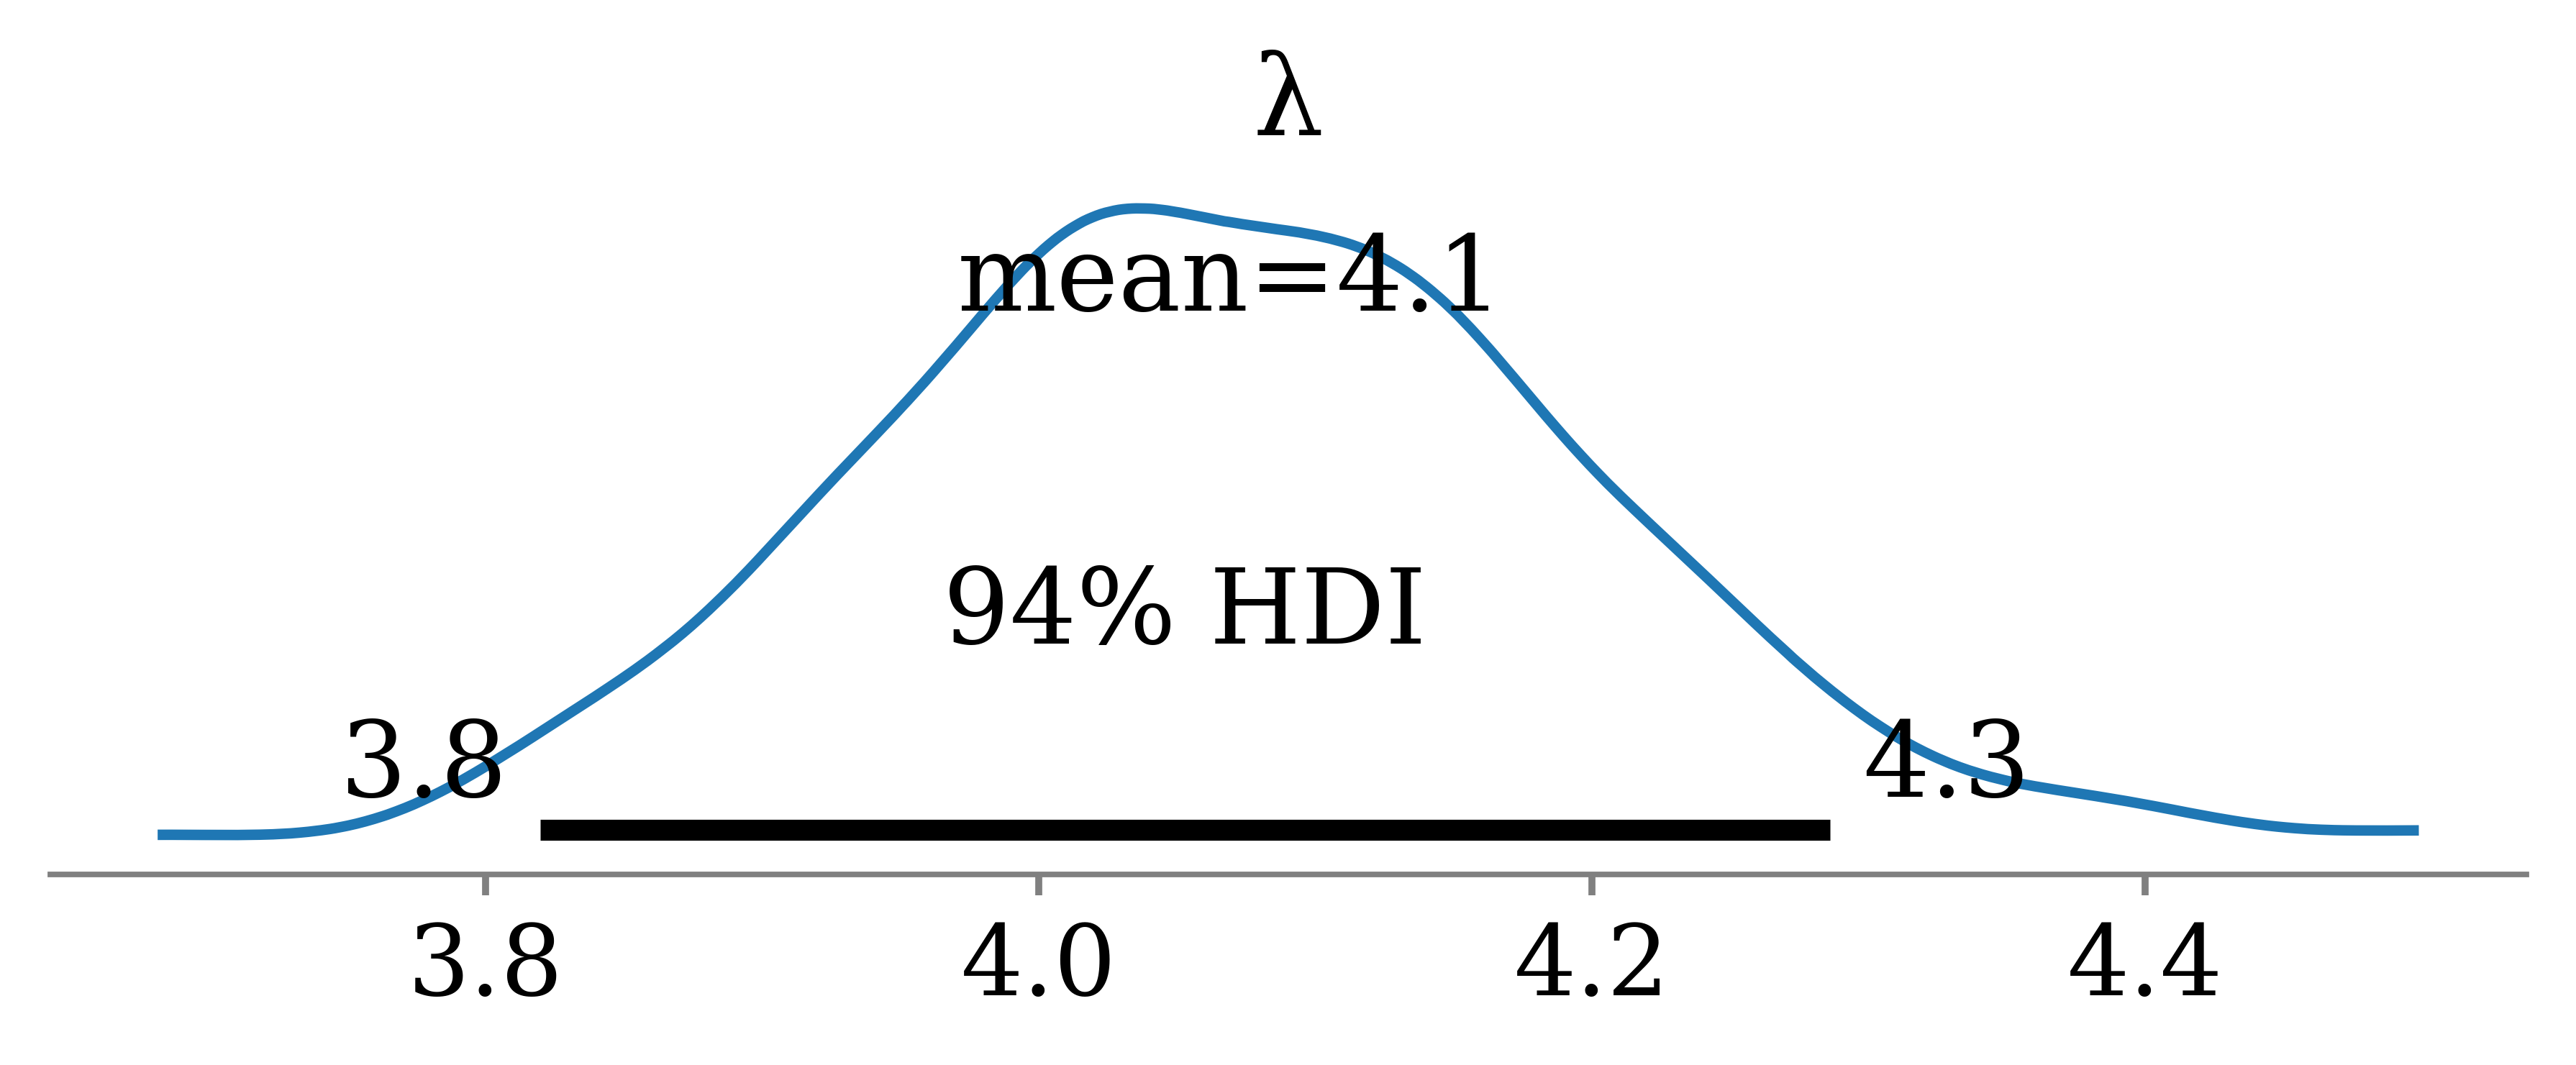

In [8]:
dffreq = pd.DataFrame({"ss": [], "λ": []})

for ss in sample_sizes:
    nData = df_agg.N[df_agg.time_period <= ss]
    with pm.Model() as model_negbin:
        λ = pm.Uniform("λ", lower=0, upper=10)
        N = pm.Poisson("N", mu=λ, observed=nData)

        %time trace = pm.sample_smc(popSize, random_seed=1, chains = 1)
        arviz.plot_posterior(trace)

    res = pd.DataFrame({"ss": np.repeat(ss, popSize), "λ": trace["λ"]})
    dffreq = pd.concat([dffreq, res])

We store all the posterior samples in one single data frame

In [9]:
dftrue = pd.concat([dffreq, dfsev.drop("ss", axis=1)], axis=1)
dftrue["posterior"] = np.repeat("True", len(dftrue))

## ABC posterior for the Poisson - frequency dependent exponential model

In [10]:
params = ("λ", "β", "δ")
prior = abcre.IndependentUniformPrior([(0, 10), (0, 20), (-1, 1)], params)
model = abcre.Model("poisson", "frequency dependent exponential", psi, prior)

In [11]:
dfABC = pd.DataFrame({"ss": [], "weights": [], "λ": [], "β": [], "δ": []})

for ss in sample_sizes:
    xDataSS = df_agg.X[df_agg.time_period <= ss].to_numpy()

    %time fit = abcre.smc(numIters, popSize, xDataSS, model, epsMin = epsMin, **smcArgs)

    res = pd.DataFrame(
        {
            "ss": np.repeat(ss, popSize),
            "weights": fit.weights,
            "λ": fit.samples[:, 0],
            "β": fit.samples[:, 1],
            "δ": fit.samples[:, 2],
        }
    )

    dfABC = pd.concat([dfABC, res])

Final population dists <= 3.89, ESS = 786
CPU times: user 14.5 s, sys: 1.18 s, total: 15.7 s
Wall time: 23.1 s


Final population dists <= 3.51, ESS = 753
CPU times: user 8.92 s, sys: 365 ms, total: 9.28 s
Wall time: 22.4 s


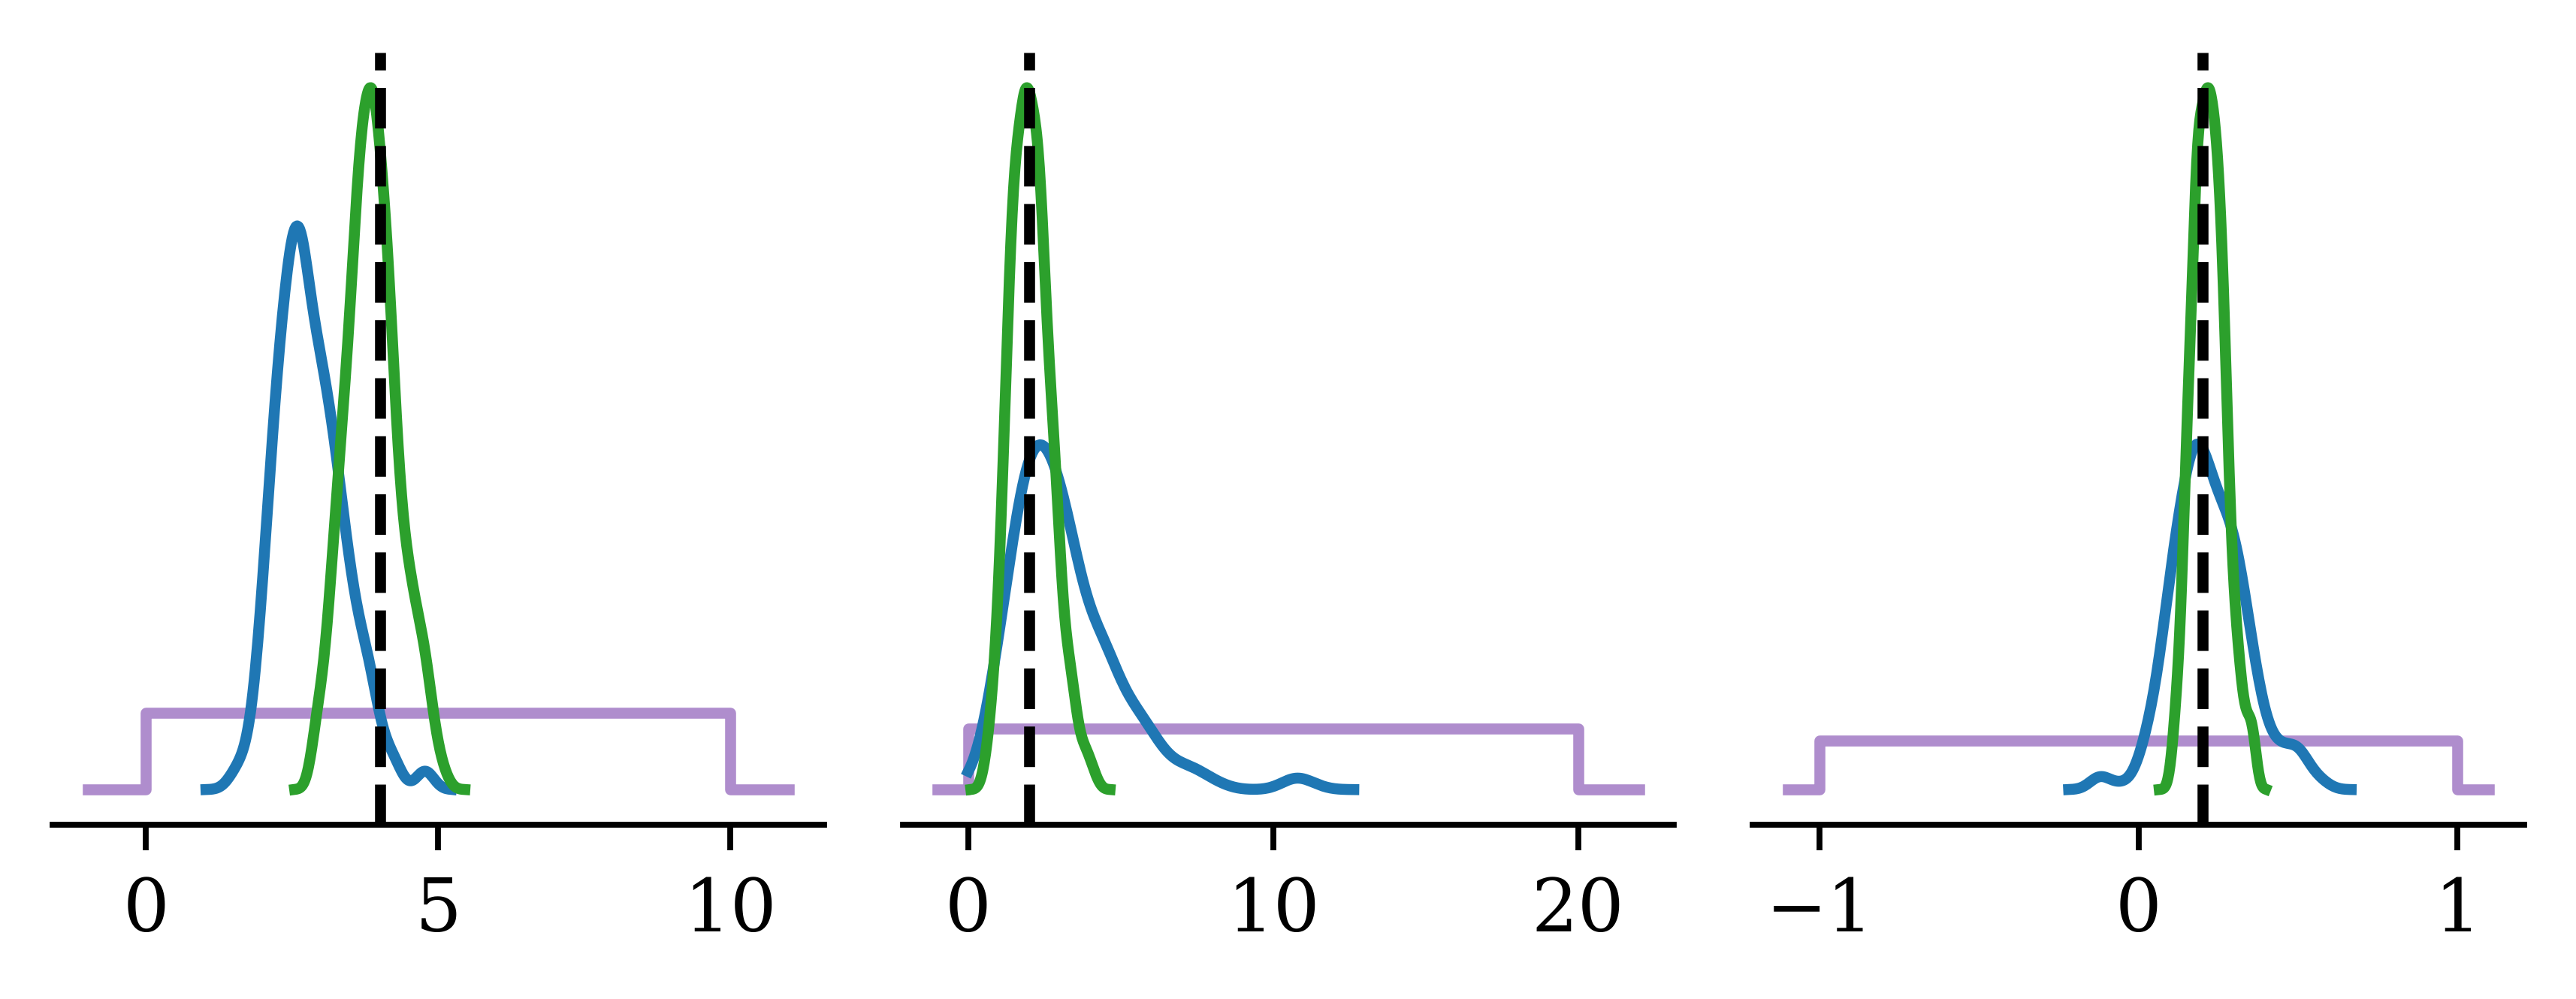

In [12]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]
    # axs[l].set_xlim(pLims)

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled, xs, ys = abcre.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label="ABC")

    axs[l].axvline(θ_True[l], **trueStyle)
    # axs[l].set_title("$" + params + "$")
    axs[l].set_yticks([])

draw_prior(prior, axs)
sns.despine(left=True)
save_cropped("../Figures/hist-test2-poisson-depexp.pdf")

/home/ubuntu/miniforge3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/miniforge3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/miniforge3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

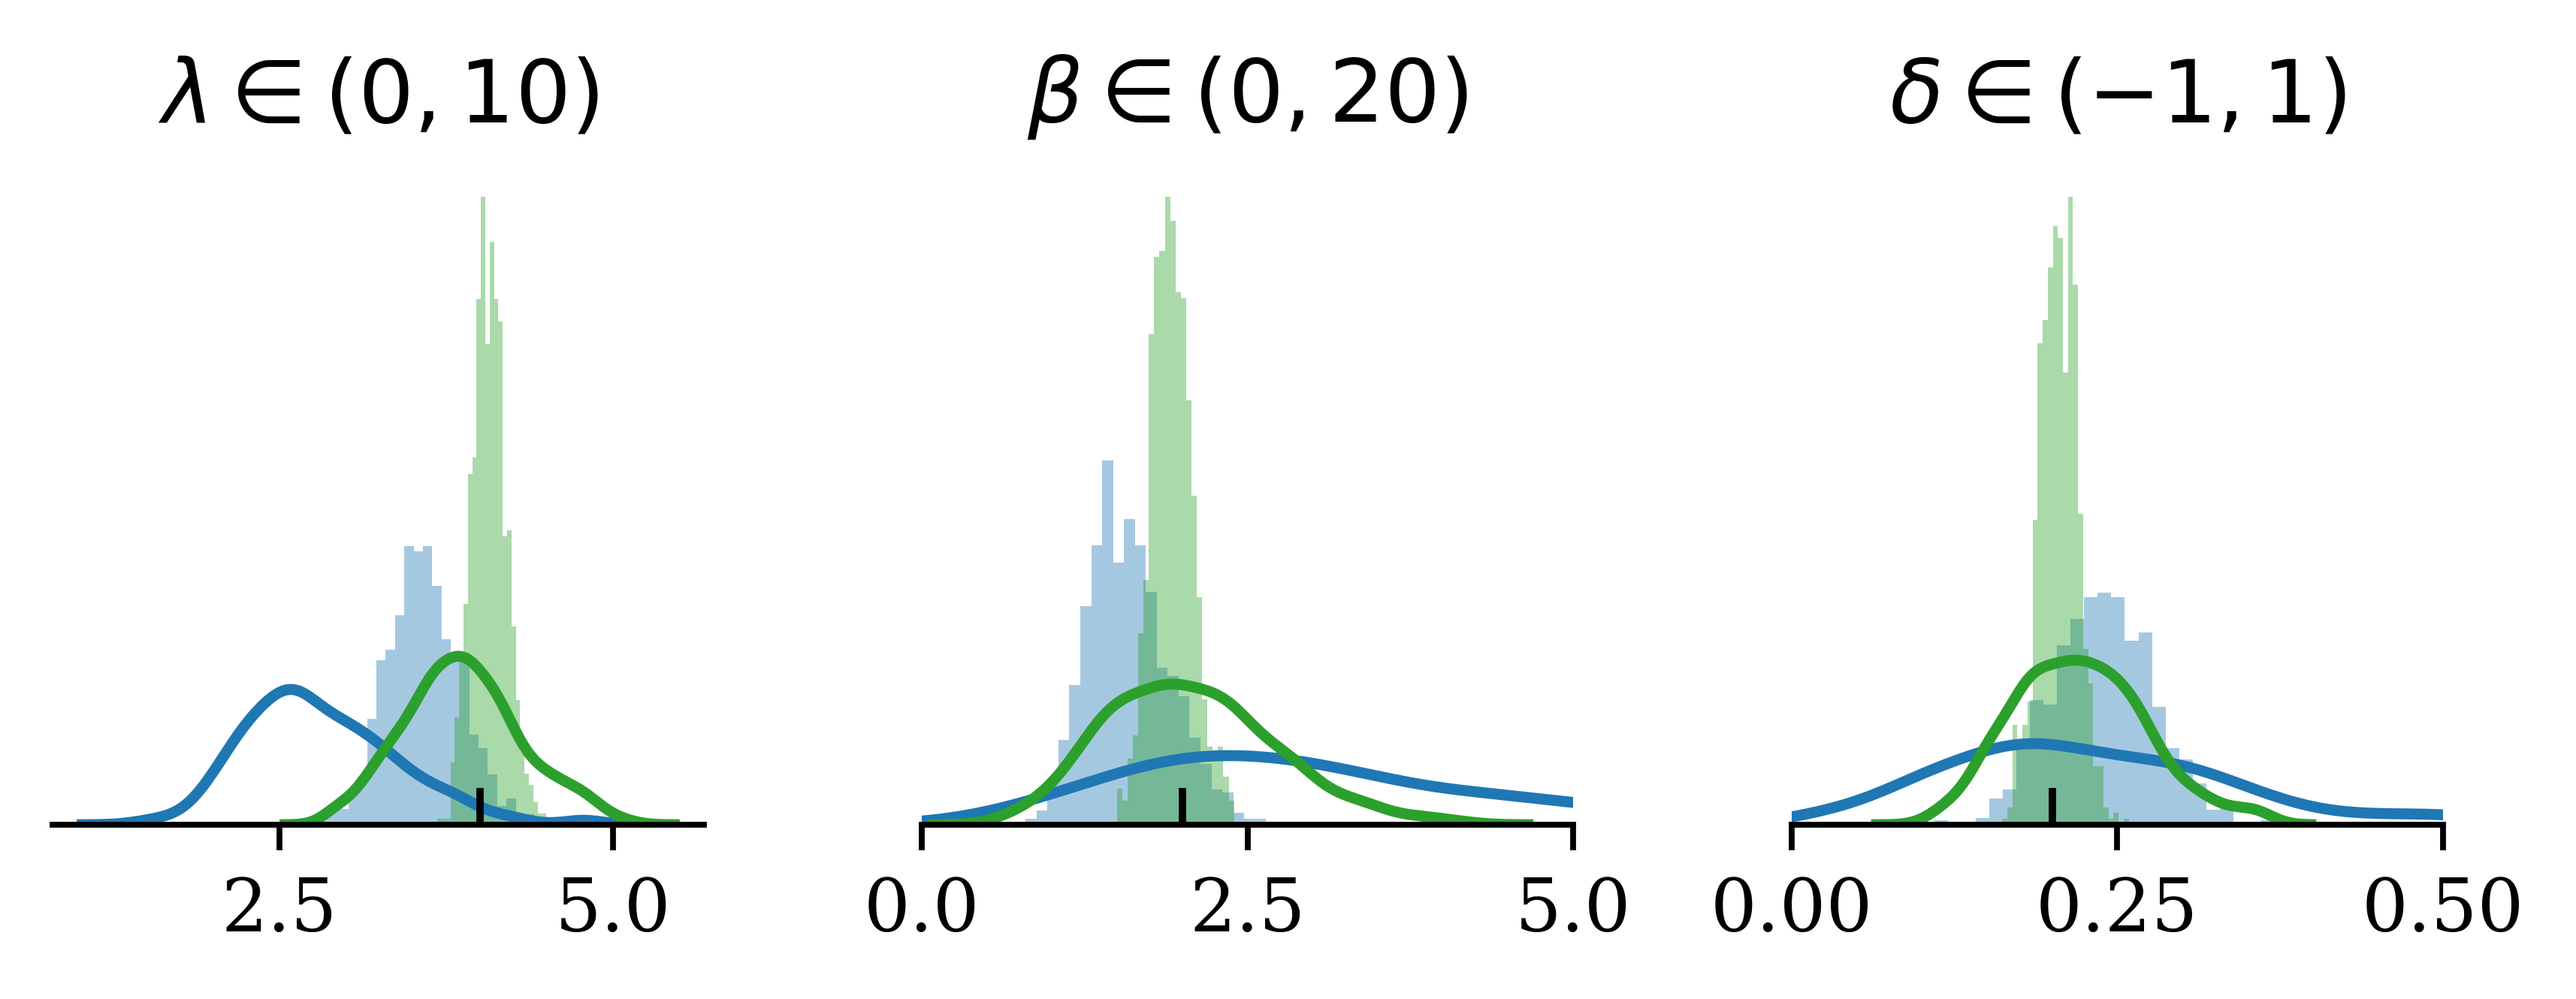

In [13]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

for l, param in enumerate(params):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]
    # axs[l].set_xlim(pLims)

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled, xs, ys = abcre.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label="ABC")

        sns.distplot(
            dftrue.query("ss == @ss")[param],
            color=colors[k],
            ax=axs[l],
            kde=False,
            hist_kws={"density": True},
        )

    # axs[l].axvline(θ_True[l], **trueStyle)
    axs[l].plot(θ_True[l], 0, color="k", marker="|", markersize=10)
    axs[l].set_title("$" + params[l] + f"\\in ({pLims[0]:.0f}, {pLims[1]:.0f})$")
    axs[l].set_yticks([])
    axs[l].set_xlabel("")

axs[1].set_xlim([0, 5])
axs[2].set_xlim([0, 0.5])

sns.despine(left=True)
# save_cropped("../Figures/hist-test2-poisson-depexp-approximate.pdf")

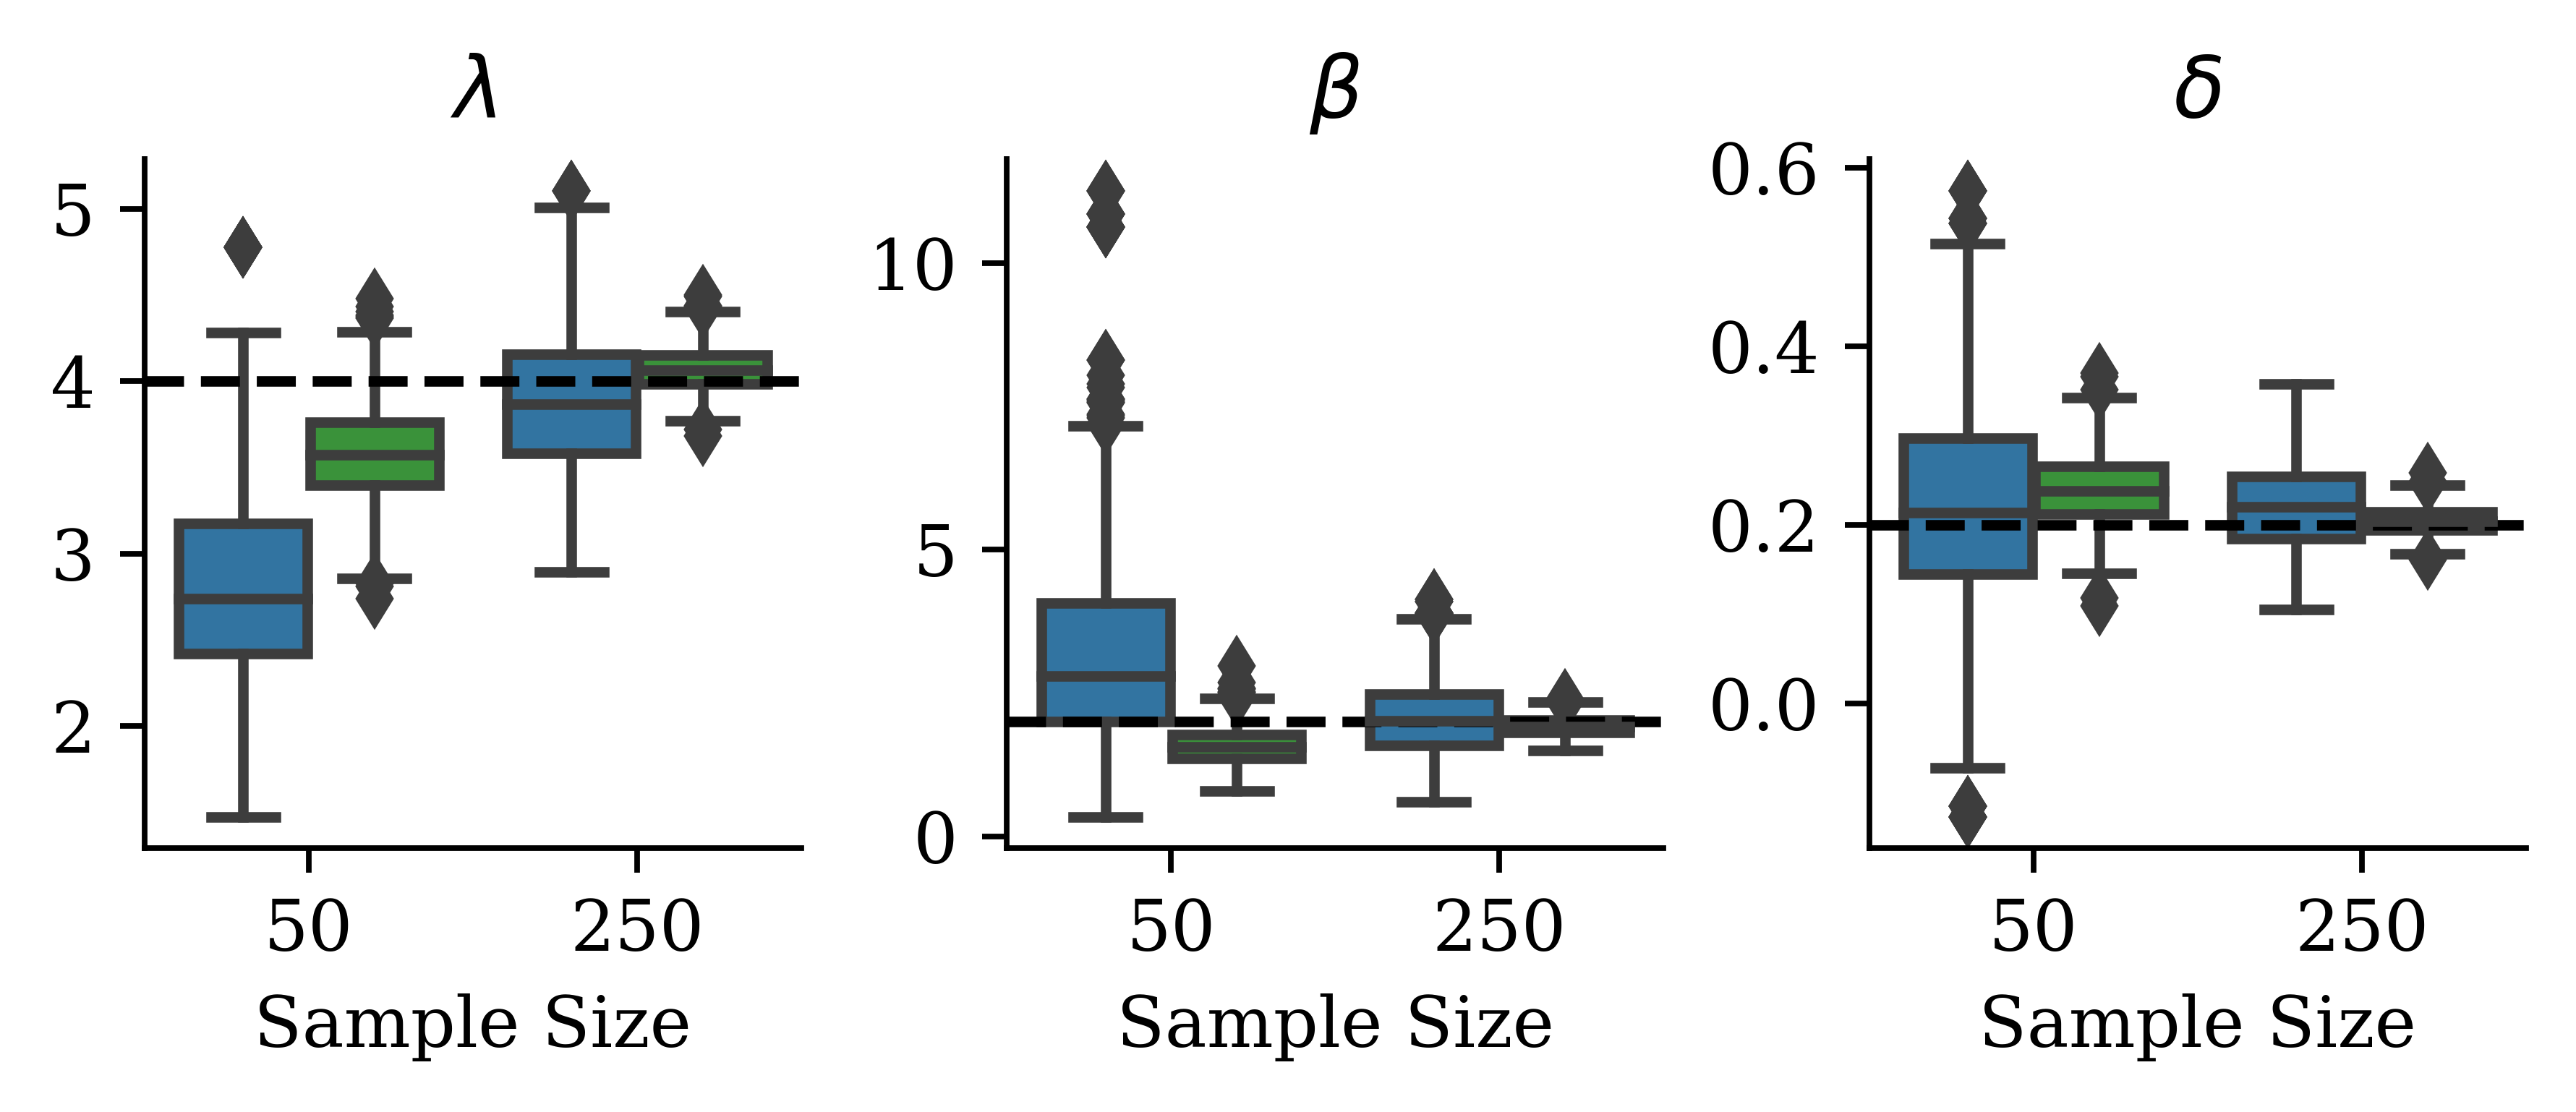

In [14]:
rg = default_rng(1)

n_resample = 1
resampled_post_ABC = pd.DataFrame(
    {"ss": np.concatenate([np.repeat(ss, popSize * n_resample) for ss in sample_sizes])}
)

for l in range(len(params)):
    res_param = np.array([])
    for ss in sample_sizes:
        sampleData = dfABC.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled = sample[abcre.resample(rg, weights, repeats=n_resample)]
        res_param = np.concatenate([res_param, dataResampled])

    resampled_post_ABC[params[l]] = res_param

resampled_post_ABC["posterior"] = np.repeat(
    "ABC", len(sample_sizes) * popSize * n_resample
)
post_samples = pd.concat([resampled_post_ABC, dftrue], axis=0)

post_samples["ss"] = post_samples["ss"].astype(np.int64)

for l in range(len(params)):
    plt.subplot(1, len(params), l + 1)
    plt.tight_layout(pad=0.0)
    g = sns.boxplot(x="ss", y=params[l], hue="posterior", data=post_samples)
    plt.gca().axhline(θ_True[l], **trueStyle)
    plt.title("$" + params[l] + "$")
    plt.ylabel("")
    plt.xlabel("Sample Size")
    plt.legend("", frameon=False)

sns.despine()
# save_cropped("../Figures/boxplot-test2-poisson-depexp.pdf")

## ABC posterior for the dependent exponential parameters with the claim frequency

In [15]:
params = ("β", "δ")
prior = abcre.IndependentUniformPrior([(0, 20), (-1, 1)], params)

In [16]:
dfABC_freq = pd.DataFrame({"ss": [], "weights": [], "β": [], "δ": []})

for ss in sample_sizes:
    xDataSS = df_agg.X[df_agg.time_period <= ss].to_numpy()
    nData = np.array(df_agg.N[df_agg.time_period <= ss])

    model = abcre.Model(nData, "frequency dependent exponential", psi, prior)

    %time fit = abcre.smc(numItersData, popSize, xDataSS, model, epsMin = epsMin, **smcArgs)

    res = pd.DataFrame(
        {
            "ss": np.repeat(ss, popSize),
            "weights": fit.weights,
            "β": fit.samples[:, 0],
            "δ": fit.samples[:, 1],
        }
    )

    dfABC_freq = pd.concat([dfABC_freq, res])

Final population dists <= 2.57, ESS = 871
CPU times: user 18.8 s, sys: 750 ms, total: 19.5 s
Wall time: 19 s


Final population dists <= 1.78, ESS = 916
CPU times: user 18.4 s, sys: 778 ms, total: 19.2 s
Wall time: 18.9 s


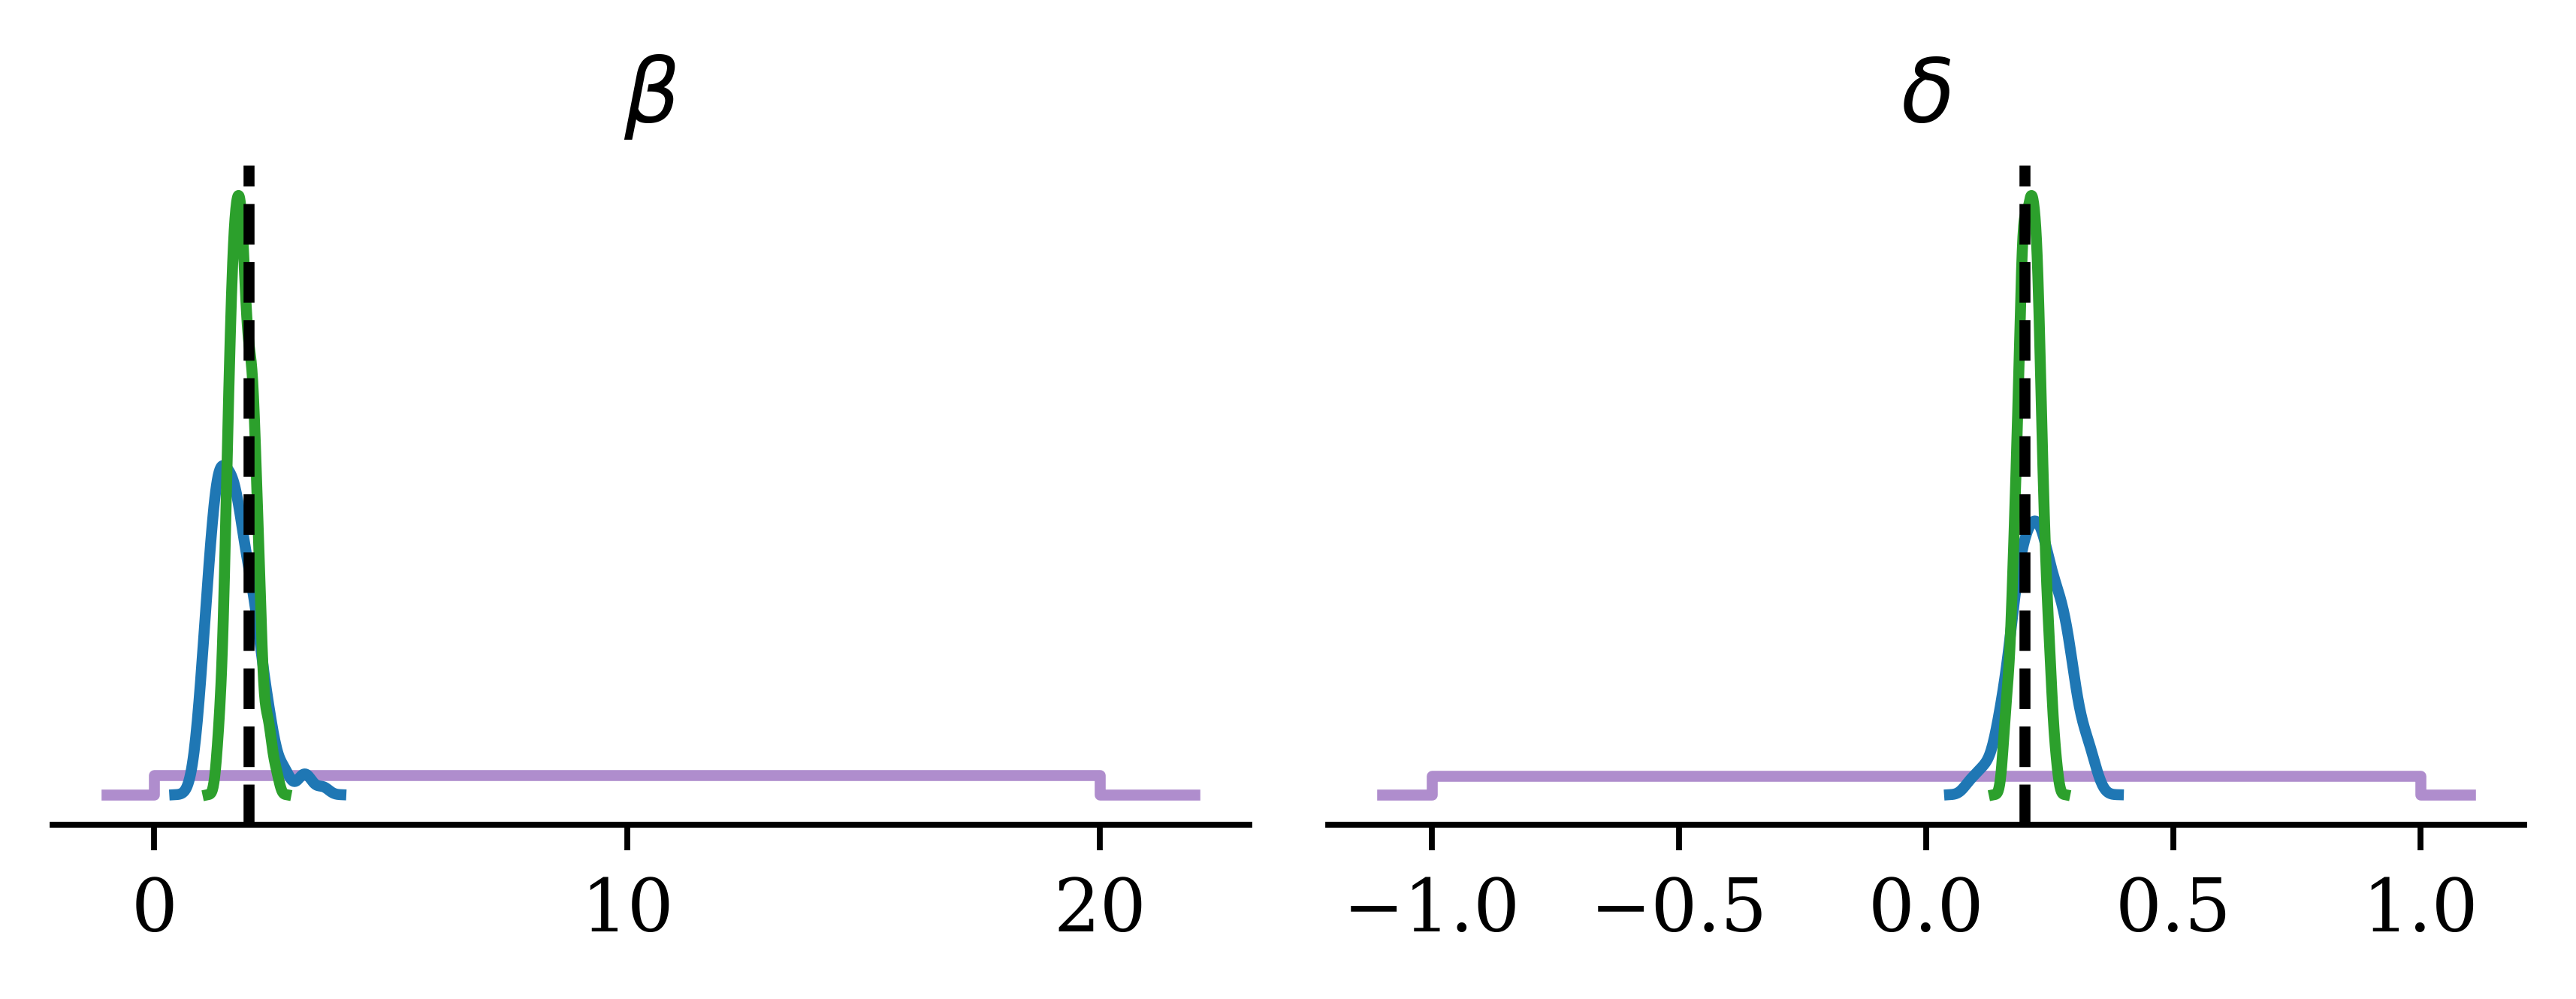

In [17]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC_freq.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled, xs, ys = abcre.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label="ABC")

    axs[l].axvline(θ_sev[l], **trueStyle)
    axs[l].set_title("$" + params[l] + "$")
    axs[l].set_yticks([])

draw_prior(prior, axs)
sns.despine(left=True)
# save_cropped("../Figures/hist-test2-poisson-depexp-freq.pdf")

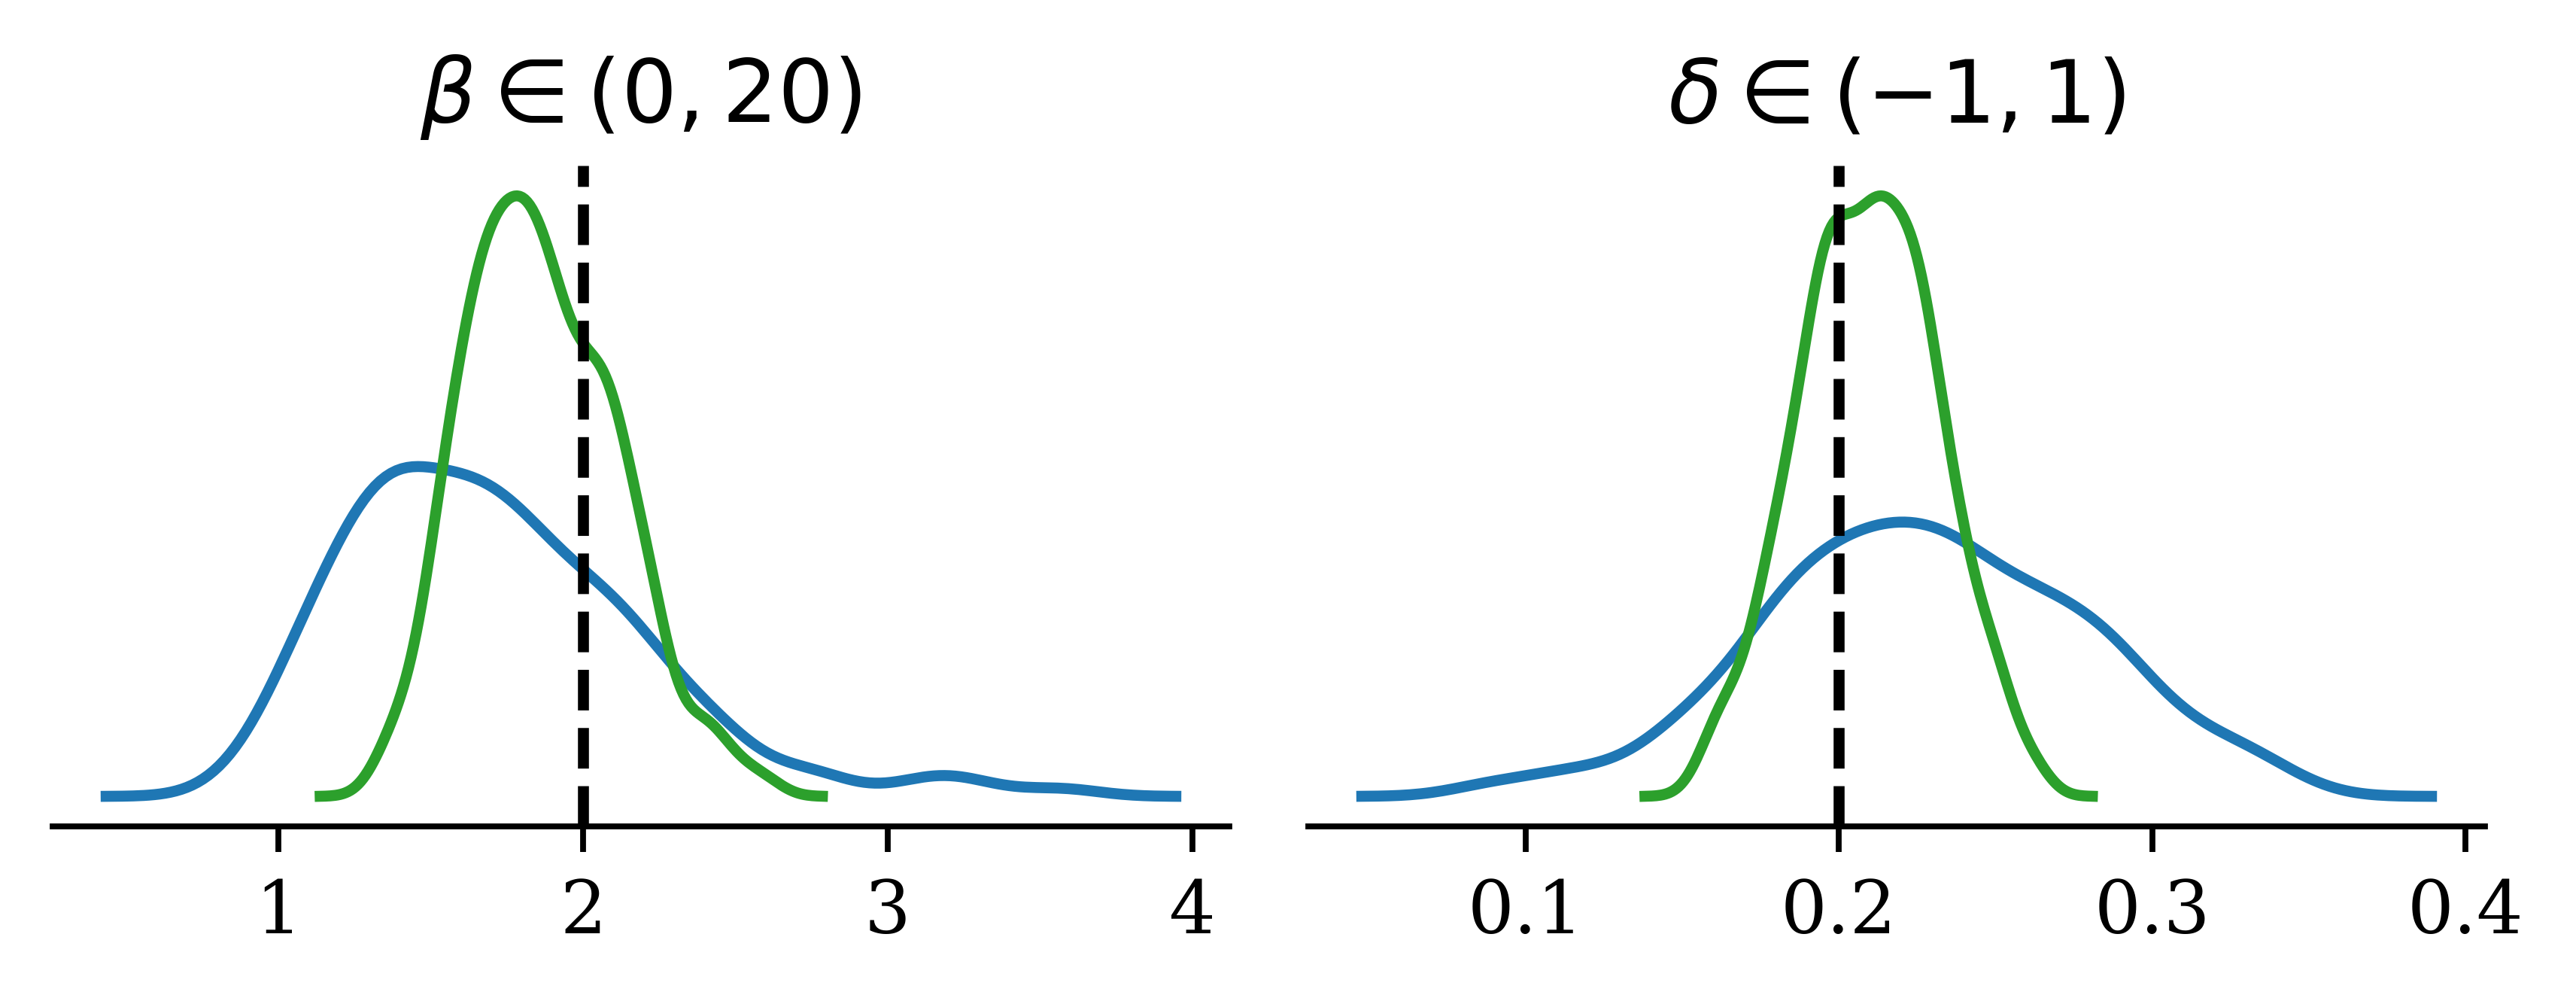

In [18]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC_freq.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled, xs, ys = abcre.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label="ABC")

    axs[l].axvline(θ_sev[l], **trueStyle)
    axs[l].set_title("$" + params[l] + f"\\in ({pLims[0]:.0f}, {pLims[1]:.0f})$")
    axs[l].set_yticks([])

sns.despine(left=True)
# save_cropped("../Figures/hist-test2-poisson-depexp-freq-zoomed.pdf")

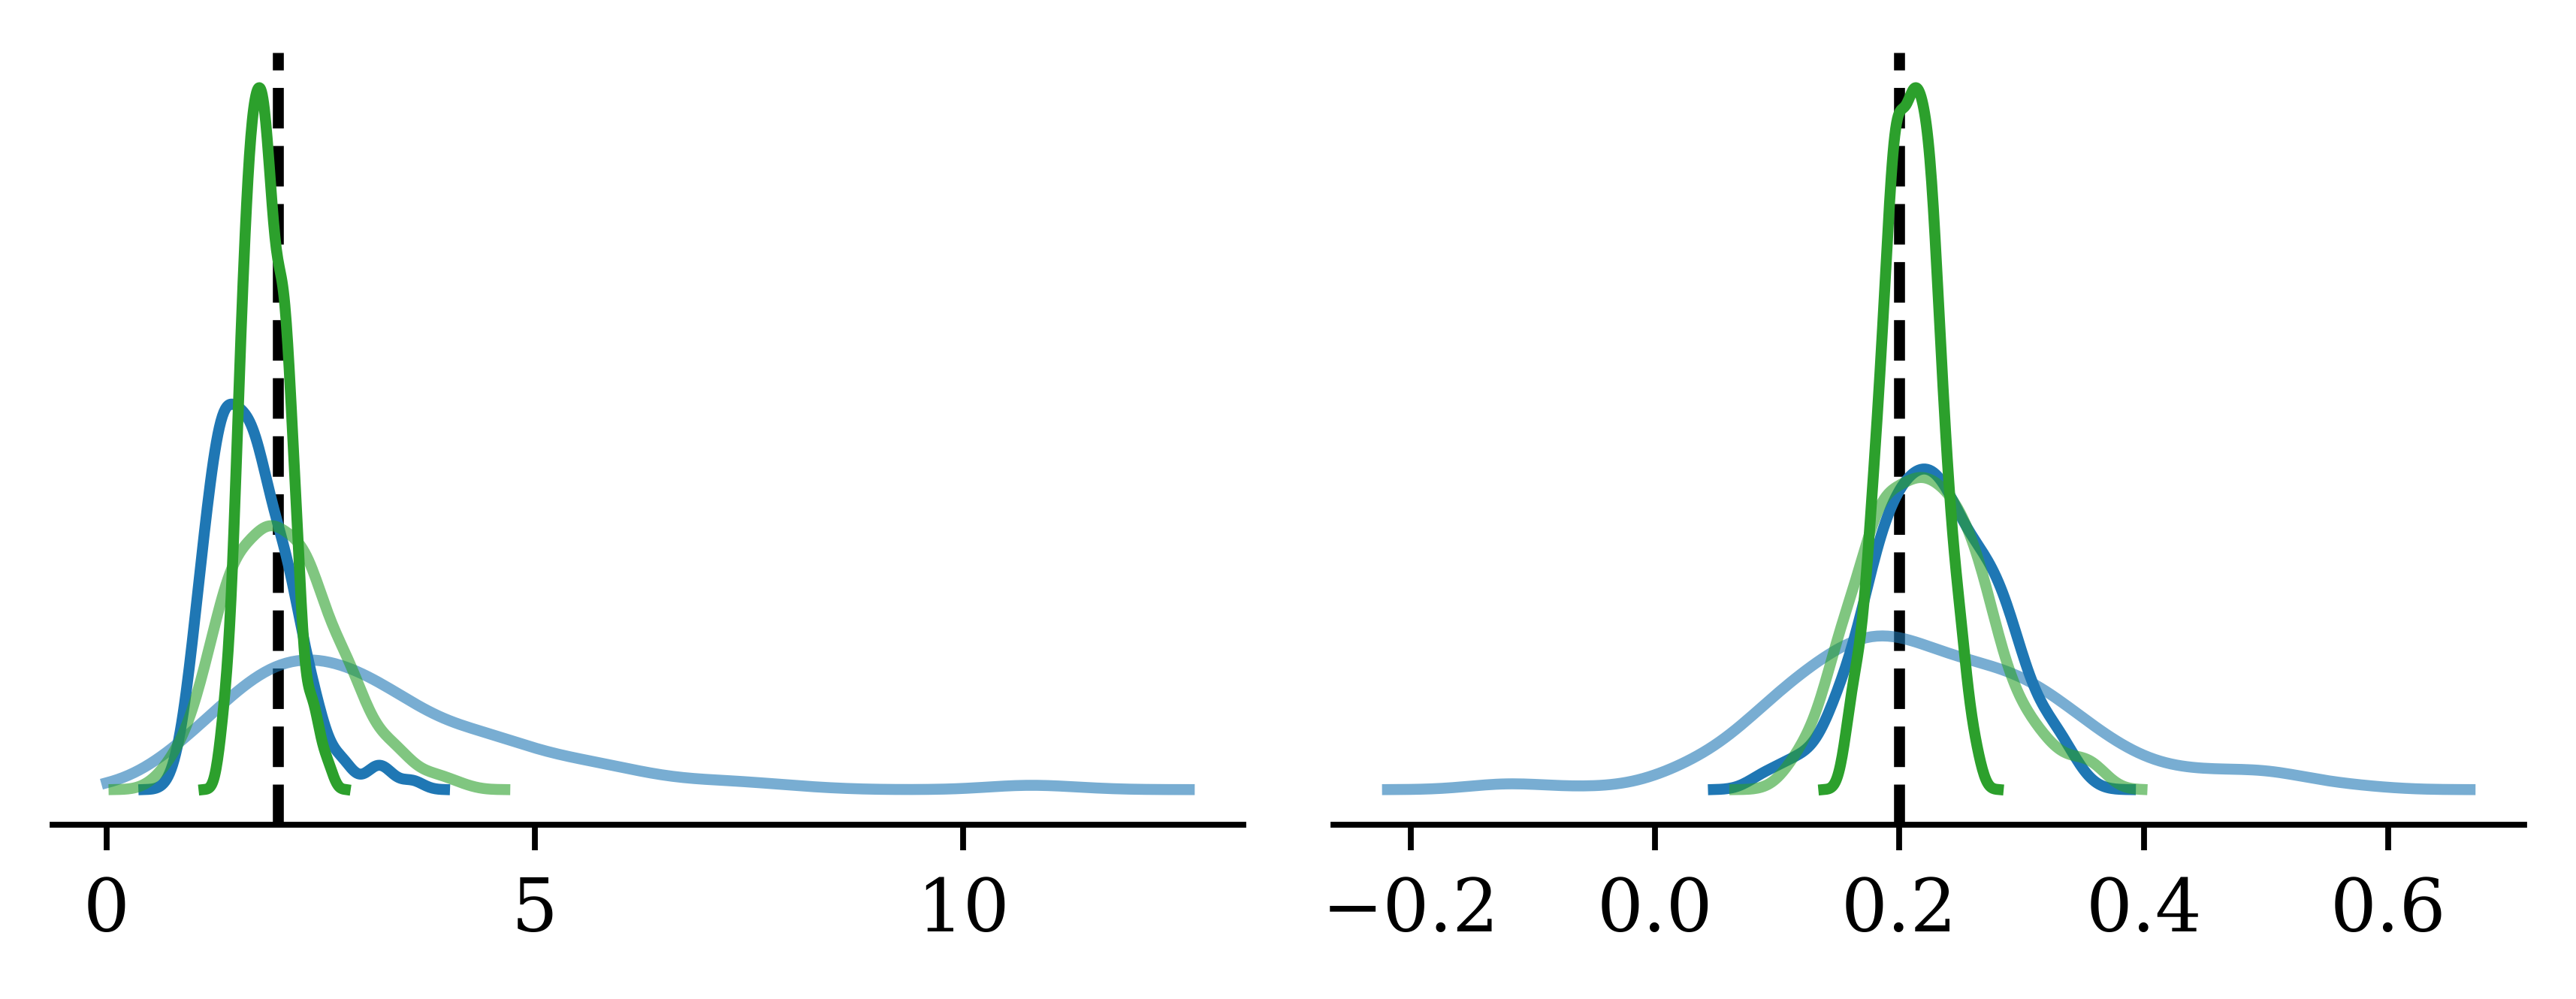

In [19]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

alphas = (0.6, 1)

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]

    axs[l].axvline(θ_sev[l], **trueStyle)
    axs[l].set_yticks([])
    for k, ss in enumerate(sample_sizes):

        for j, df in enumerate((dfABC, dfABC_freq)):
            sampleData = df.query("ss == @ss")
            sample = sampleData[params[l]]
            weights = sampleData["weights"]

            dataResampled, xs, ys = abcre.resample_and_kde(sample, weights, clip=pLims)
            axs[l].plot(xs, ys, label="ABC", alpha=alphas[j], c=colors[k])

            # axs[l].set_title("$" + params[l] + "$")

sns.despine(left=True)
save_cropped("../Figures/hist-test2-poisson-depexp-both.pdf")

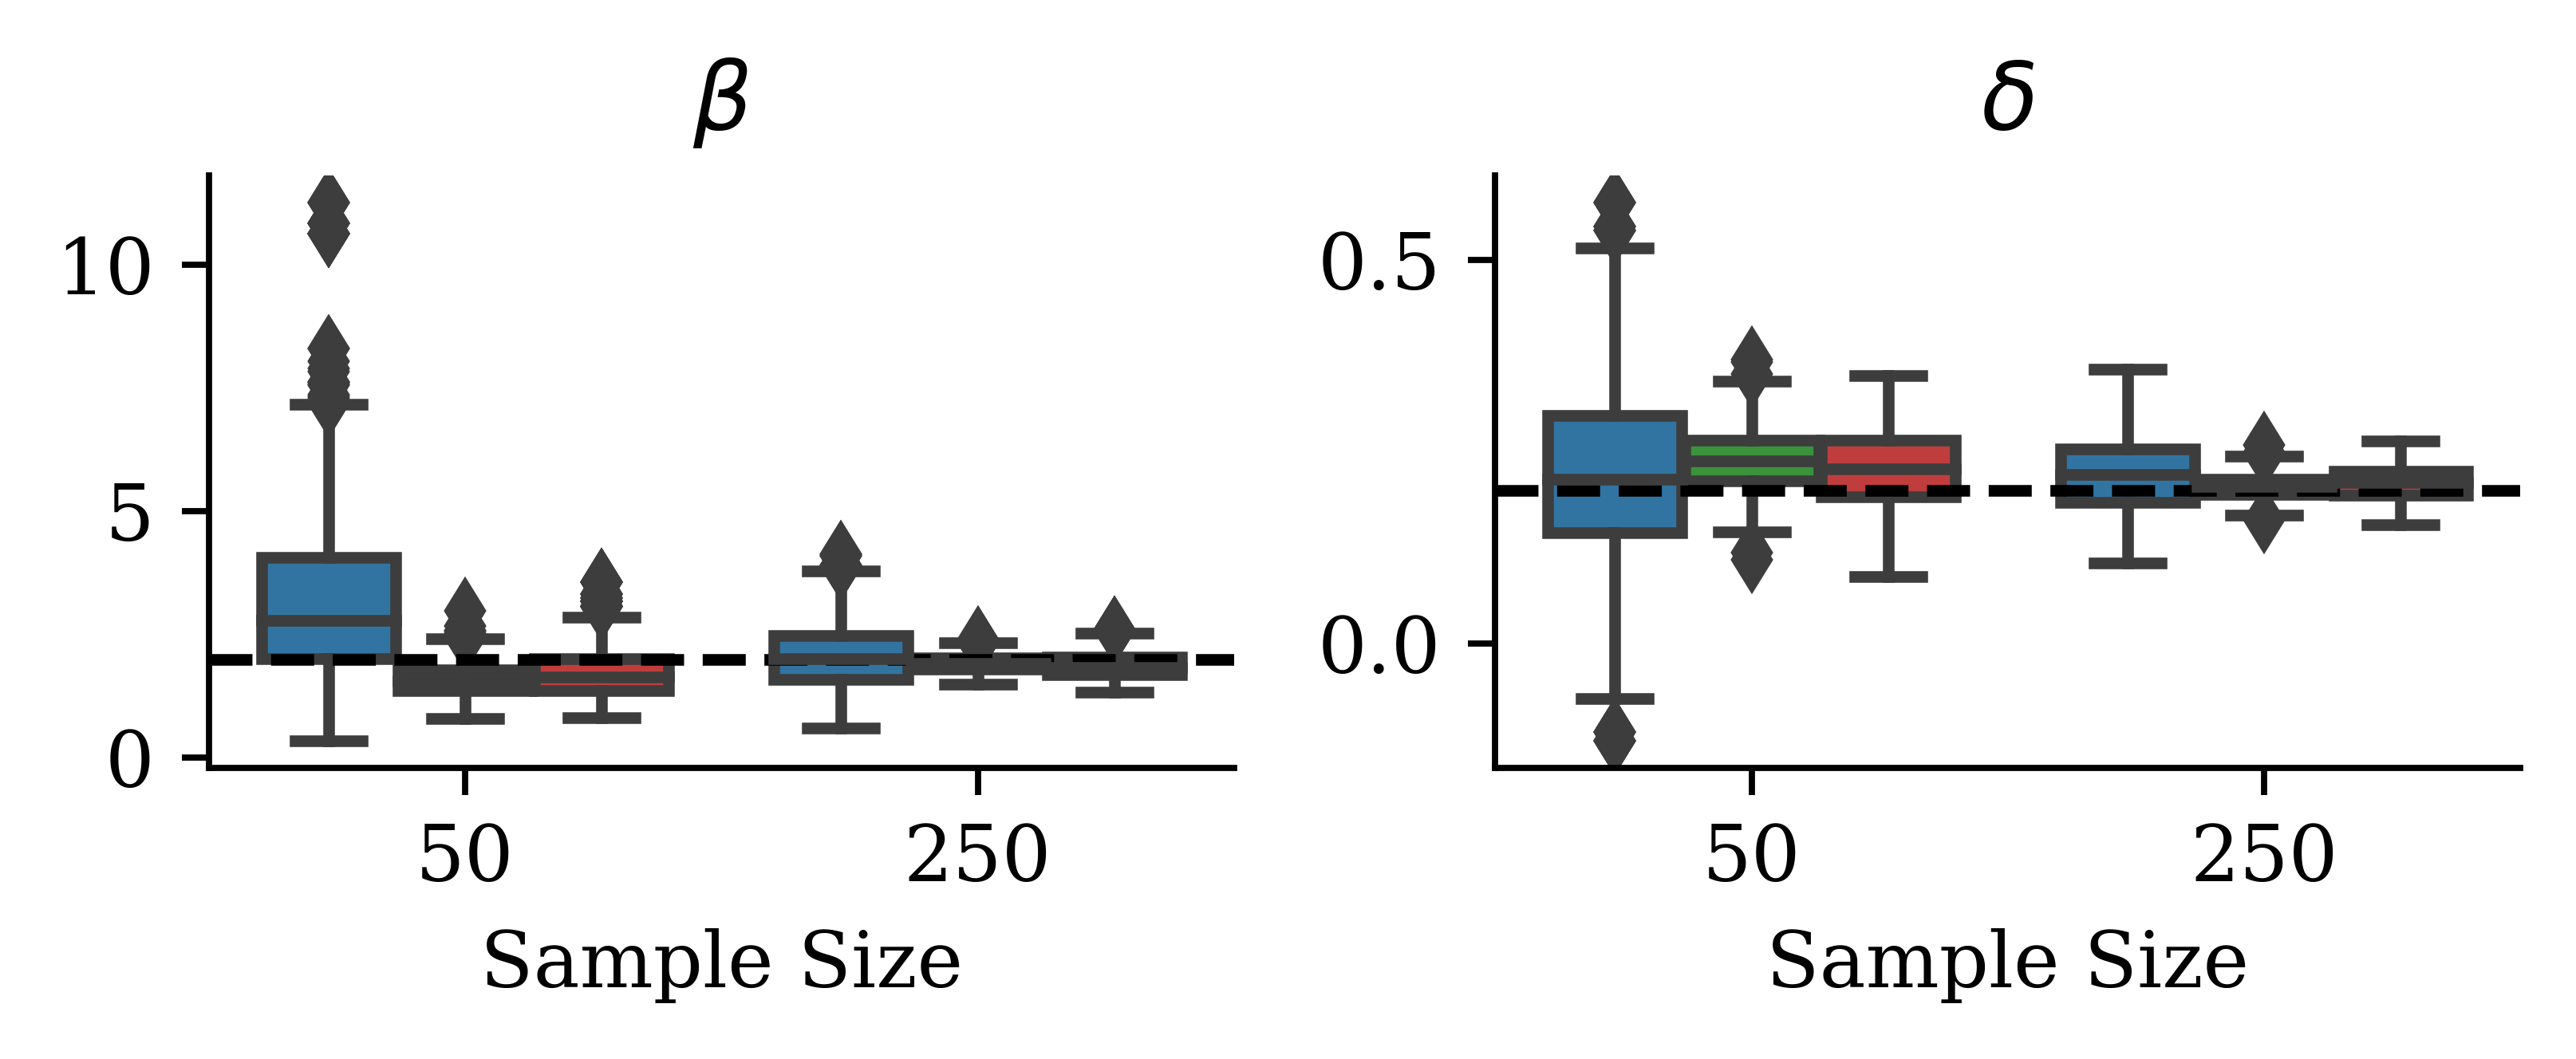

In [20]:
rg = default_rng(1234)

resampled_post_ABC_freq = pd.DataFrame(
    {"ss": np.concatenate([np.repeat(ss, popSize * n_resample) for ss in sample_sizes])}
)

for l in range(len(params)):
    res_param = np.array([])
    for ss in sample_sizes:
        sampleData = dfABC_freq.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled = sample[abcre.resample(rg, weights, repeats=n_resample)]
        res_param = np.concatenate([res_param, dataResampled])

    resampled_post_ABC_freq[params[l]] = res_param

resampled_post_ABC_freq["posterior"] = np.repeat(
    "ABC with freq.", len(sample_sizes) * popSize * n_resample
)
dfV2 = pd.concat([post_samples, resampled_post_ABC_freq], axis=0)

dfV2["ss"] = dfV2["ss"].astype(np.int64)

for l in range(len(params)):
    plt.subplot(1, len(params), l + 1)
    plt.tight_layout()
    sns.boxplot(x="ss", y=params[l], hue="posterior", data=dfV2)
    plt.gca().axhline(θ_sev[l], **trueStyle)
    plt.title("$" + params[l] + "$")
    plt.ylabel("")
    plt.xlabel("Sample Size")
    plt.legend("", frameon=False)

sns.despine()
# save_cropped("../Figures/boxplot-test2-poisson-depexp-freq.pdf")

In [21]:
elapsed = toc()
print(f"Notebook time = {elapsed:.0f} secs = {elapsed/60:.2f} mins")

Notebook time = 104 secs = 1.73 mins


In [22]:
dill.dump_session("Sim_Poisson_Depexp.pkl")